In [1]:
# Cell 1: Imports and Setup
print("--- Start Cell 1 ---")

# --- Imports ---
import os
import sys
from pathlib import Path
import logging
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time # Make sure time is imported

# --- Add project root to sys.path ---
# Assuming the notebook is in the 'notebooks' directory
try:
    # Get current working directory in the notebook
    notebook_dir = Path(os.getcwd())
    project_root = notebook_dir.parent # Go up one level from 'notebooks'
    if not (project_root / 'src').exists() or not (project_root / 'config').exists():
         # Fallback if not run from notebooks dir (e.g., opened directly in root)
         if (notebook_dir / 'src').exists() and (notebook_dir / 'config').exists():
              project_root = notebook_dir
         else:
              # Attempt relative path calculation robustly
              script_path = Path(__file__).parent # This might fail in notebook context
              project_root = script_path.parent.parent
              if not (project_root / 'src').exists():
                   raise OSError("Could not reliably determine project root directory.")

    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    print(f"Project Root added to sys.path: {project_root}")
    print(f"System Path: {sys.path}")

except Exception as path_e:
     print(f"ERROR determining project root: {path_e}")
     # Hardcode path if necessary for debugging, but not ideal:
     # project_root = Path('/workspaces/GeminiTrader') # Example
     # if str(project_root) not in sys.path:
     #    sys.path.insert(0, str(project_root))
     print("!!! Warning: Could not reliably set project path. Imports might fail. !!!")


# --- Project Imports ---
print("Importing project modules...")
try:
    from config.settings import load_config
    print("Successfully imported load_config")
    from src.utils.logging_setup import setup_logging
    print("Successfully imported setup_logging")
    from src.utils.formatting import to_decimal
    print("Successfully imported to_decimal")
    from src.connectors.binance_us import BinanceUSConnector
    print("Successfully imported BinanceUSConnector")
    from src.data.kline_fetcher import fetch_and_prepare_klines
    print("Successfully imported fetch_and_prepare_klines")
    from src.analysis.indicators import calculate_atr
    print("Successfully imported calculate_atr")
    from src.backtester.engine import Backtester
    print("Successfully imported Backtester")
    import src.db.manager # Import to ensure DBManager is available if used
    print("Successfully imported src.db.manager")
except ImportError as e:
    # This block should now catch genuine import errors
    print(f"ERROR: Failed to import project modules. Check path and environment. Error: {e}")
    # Stop execution if core components are missing
    raise ImportError(f"Core module import failed: {e}") from e
except Exception as general_e:
     print(f"ERROR: An unexpected error occurred during imports: {general_e}")
     raise

# --- Basic Logging Setup for Notebook ---
# (Configure simple logging to console for notebook output)
log_dir_nb = project_root / "data" / "logs"
log_file_nb = log_dir_nb / "notebook_backtest.log"
log_dir_nb.mkdir(parents=True, exist_ok=True)
# Use basicConfig for simplicity in notebooks unless detailed file logging is needed
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    handlers=[logging.StreamHandler()]) # Log to console output
logger = logging.getLogger(__name__)
logger.info("Notebook basic logging configured.")

# --- Matplotlib Setup ---
# No need for %matplotlib inline in modern VS Code Jupyter renderers
plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style

print("--- End Cell 1 ---")

--- Start Cell 1 ---
Project Root added to sys.path: /workspaces/GeminiTrader
System Path: ['/workspaces/GeminiTrader', '/usr/local/lib/python312.zip', '/usr/local/lib/python3.12', '/usr/local/lib/python3.12/lib-dynload', '', '/home/vscode/.local/lib/python3.12/site-packages', '/usr/local/lib/python3.12/site-packages']
Importing project modules...
Successfully imported load_config
Successfully imported setup_logging
Successfully imported to_decimal
Successfully imported BinanceUSConnector
Successfully imported fetch_and_prepare_klines
Successfully imported calculate_atr


2025-04-13 20:58:13,308 - __main__ - INFO - Notebook basic logging configured.


Successfully imported Backtester
Successfully imported src.db.manager
--- End Cell 1 ---


In [2]:
# Cell 2: Configuration Loading
# Use logger for start/end markers for consistent output ordering
logger.info("--- Start Cell 2 ---")

# --- Load Configuration ---
logger.info("Loading configuration...")
# Load config using the function from settings.py
config = load_config()
if not config:
    logger.error("Failed to load configuration. Stopping notebook execution.")
    raise ValueError("Configuration loading failed.")

# --- Define Backtest Parameters ---
# You can override parameters from config here if desired for specific tests
backtest_symbol = 'BTCUSD' # Symbol to backtest
backtest_interval = '1h' # Kline interval
backtest_start_date = '90 days ago UTC' # Start date for data loading/fetching
backtest_end_date = 'now UTC' # End date for data loading/fetching

# Strategy parameters (can be taken from config or defined here)
# Example: Get geometric grid strategy config
# Use get_config_value for safe access
strategy_params = config.get('strategies', {}).get('geometric_grid', {})

if not strategy_params:
    logger.warning("Geometric grid strategy params not found in config, using defaults.")
    # Define fallback defaults if needed (better to have them in config.yaml)
    strategy_params = {
        'base_order_size_usd': '100.00',
        'grid_spacing_atr_multiplier': '0.4',
        'grid_spacing_geometric_factor': '1.1',
        'order_size_geometric_factor': '1.2',
        'max_grid_levels': 5,
        'max_total_grid_quantity_base': '0.5',
        'atr_length': 14,
        'tp_method': 'percentage',
        'tp_value': '0.015'
    }
# Ensure values that should be Decimal are Decimal (load_config handles many, but verify)
# Example: Manually convert if load_config didn't or if overriding here
numeric_strategy_keys = [
    'base_order_size_usd', 'grid_spacing_atr_multiplier', 'grid_spacing_geometric_factor',
    'order_size_geometric_factor', 'max_total_grid_quantity_base', 'tp_value'
]
for key in numeric_strategy_keys:
    if key in strategy_params:
        strategy_params[key] = to_decimal(strategy_params[key])
        if strategy_params[key] is None:
             logger.error(f"Failed to convert strategy param '{key}' to Decimal. Check config/value.")
             raise ValueError(f"Invalid strategy parameter: {key}")

# Convert atr_length to int
if 'atr_length' in strategy_params:
     try:
         strategy_params['atr_length'] = int(strategy_params['atr_length'])
     except (ValueError, TypeError):
          logger.error(f"Invalid atr_length '{strategy_params['atr_length']}'. Using default 14.")
          strategy_params['atr_length'] = 14


# Get portfolio/fee settings safely using get_config_value or defaults
initial_portfolio_cash = config.get('portfolio', {}).get('initial_cash', Decimal('10000.0'))
maker_fee_pct = config.get('fees', {}).get('maker', Decimal('0.001'))
taker_fee_pct = config.get('fees', {}).get('taker', Decimal('0.001'))

# Ensure these are also Decimal
initial_portfolio_cash = to_decimal(initial_portfolio_cash, Decimal('10000.0'))
maker_fee_pct = to_decimal(maker_fee_pct, Decimal('0.001'))
taker_fee_pct = to_decimal(taker_fee_pct, Decimal('0.001'))


backtest_run_id = f"nb_{backtest_symbol}_{backtest_interval}_{int(time.time())}"

logger.info(f"Backtest Parameters:")
logger.info(f"  Symbol: {backtest_symbol}")
logger.info(f"  Interval: {backtest_interval}")
logger.info(f"  Start Date: {backtest_start_date}")
logger.info(f"  End Date: {backtest_end_date}")
logger.info(f"  Initial Cash: {initial_portfolio_cash}")
logger.info(f"  Maker Fee: {maker_fee_pct*Decimal(100):.4f}%")
logger.info(f"  Taker Fee: {taker_fee_pct*Decimal(100):.4f}%")
# Use pformat for potentially cleaner multi-line dict logging
import pprint
strategy_log_str = pprint.pformat(strategy_params)
logger.info(f"  Strategy Config:\n{strategy_log_str}")


# --- Ensure ATR Length consistency ---
atr_length = int(strategy_params.get('atr_length', 14)) # Should be int now
atr_col_name = f'ATR_{atr_length}'
logger.info(f"Expecting ATR column: {atr_col_name}")

# Use logger for end marker too
logger.info("--- End Cell 2 ---")

2025-04-13 20:58:13,320 - __main__ - INFO - --- Start Cell 2 ---
2025-04-13 20:58:13,321 - __main__ - INFO - Loading configuration...
2025-04-13 20:58:13,328 - config.settings - INFO - Loaded base configuration from: /workspaces/GeminiTrader/config/config.yaml
2025-04-13 20:58:13,329 - config.settings - INFO - Loaded 'BINANCE_US_API_KEY' from environment variable (value='GVnoNP5sIu5f0SGOuHXr1RXerW0K15Ry8KKJZJmzQosqMdGL2XTTF6GV2k55fdXZ')
2025-04-13 20:58:13,329 - config.settings - INFO - Loaded 'BINANCE_US_SECRET' from environment variable (value='bBF...WR6')
2025-04-13 20:58:13,330 - config.settings - INFO - Loaded 'COINBASE_API_KEY' from environment variable (value='YOUR_ACTUAL_COINBASE_API_KEY_HERE')
2025-04-13 20:58:13,330 - config.settings - INFO - Loaded 'COINBASE_API_SECRET' from environment variable (value='YOU...ERE')
2025-04-13 20:58:13,331 - config.settings - INFO - Loaded 'PLAID_CLIENT_ID' from environment variable (value='YOUR_ACTUAL_PLAID_CLIENT_ID_HERE')
2025-04-13 20:58:

In [3]:
# Cell 3: Load Historical Data (Best Practice Version)
logger.info("--- Start Cell 3 ---")

# --- Load Historical Data ---
data_load_start_time = time.time()
historical_data = None

# 1. Get the configured path from the loaded config (Cell 2)
data_config = config.get('data', {})
primary_csv_path_str = data_config.get('primary_kline_csv')

if not primary_csv_path_str:
    logger.error("Configuration key 'data.primary_kline_csv' not found in config.yaml.")
    raise ValueError("Missing primary_kline_csv path in configuration.")

csv_path = project_root / primary_csv_path_str # Construct Path object

logger.info(f"Attempting to load primary historical data from configured path: {csv_path}")

# 2. Load data ONLY from the configured path
if csv_path.exists():
    try:
        historical_data = pd.read_csv(csv_path, index_col='Timestamp', parse_dates=True)
        # Convert relevant columns back to Decimal
        logger.info(f"Loaded {len(historical_data)} rows from {csv_path}. Converting to Decimal...")
        conversion_errors = 0
        for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
            if col in historical_data.columns:
                converted_col = historical_data[col].apply(lambda x: to_decimal(x, default=None))
                errors_in_col = converted_col.isnull().sum()
                if errors_in_col > 0:
                    logger.warning(f"{errors_in_col} errors converting '{col}' to Decimal.")
                    conversion_errors += errors_in_col
                historical_data[col] = converted_col
            else:
                logger.warning(f"Column '{col}' not found in loaded data.")

        # Drop rows where price conversion failed
        initial_rows = len(historical_data)
        historical_data.dropna(subset=['Open', 'High', 'Low', 'Close'], inplace=True)
        rows_dropped = initial_rows - len(historical_data)
        if rows_dropped > 0:
             logger.warning(f"Dropped {rows_dropped} rows with invalid price data after conversion.")

        if historical_data.empty:
             logger.error(f"Data became empty after loading and cleaning from {csv_path}.")
             historical_data = None
        else:
              logger.info(f"Successfully loaded and processed data from configured CSV ({len(historical_data)} rows remain).")

    except Exception as e:
        logger.exception(f"Error loading or processing data from configured path {csv_path}: {e}")
        historical_data = None
else:
    # FAIL CLEARLY if the configured file doesn't exist
    logger.error(f"Configured data file not found: {csv_path}")
    logger.error(f"Please run the data fetching script first to create this file.")
    logger.error(f"Example: python scripts/fetch_historical_data.py --symbol {backtest_symbol} --interval {backtest_interval} --start \"{backtest_start_date}\" --end \"{backtest_end_date}\" --output {primary_csv_path_str}")
    raise FileNotFoundError(f"Required data file not found: {csv_path}")

# If loading failed at any point above, historical_data will be None
if historical_data is None:
     raise ValueError("Failed to load valid historical data from configured path.")

# --- Calculate ATR ---
# Use atr_col_name defined in Cell 2
if atr_col_name not in historical_data.columns:
    logger.info(f"Calculating {atr_col_name} (length={atr_length})...")
    # Use calculate_atr function (imported in Cell 1)
    historical_data = calculate_atr(historical_data, length=atr_length)
    if atr_col_name not in historical_data.columns:
        logger.error(f"Failed to calculate {atr_col_name}. Cannot proceed.")
        raise ValueError(f"ATR calculation failed for length {atr_length}.")

# Drop initial rows with NaN ATR
initial_len_data = len(historical_data)
historical_data.dropna(subset=[atr_col_name], inplace=True)
dropped_rows = initial_len_data - len(historical_data)
if dropped_rows > 0:
     logger.info(f"Dropped {dropped_rows} rows with NaN ATR.")

if historical_data.empty:
    logger.error("Historical data is empty after processing ATR. Cannot run backtest.")
    raise ValueError("No valid historical data available after ATR calculation.")

data_load_end_time = time.time()
logger.info(f"Data preparation complete ({len(historical_data)} bars). Time taken: {data_load_end_time - data_load_start_time:.2f}s")
print("\nSample of prepared data:")
# Display head and tail using markdown for better formatting in notebooks
pd.set_option('display.max_columns', 10) # Limit columns for markdown
try:
    print(historical_data.head().to_markdown(numalign="right", stralign="right"))
    print("\n...")
    print(historical_data.tail().to_markdown(numalign="right", stralign="right"))
except ImportError:
    logger.error("Tabulate library not found. Cannot display markdown table. Use pip install tabulate.")
    # Fallback to standard print
    print(historical_data.head())
    print("\n...")
    print(historical_data.tail())
finally:
    pd.reset_option('display.max_columns') # Reset display option

# Use logger for end marker
logger.info("--- End Cell 3 ---")

2025-04-13 20:58:13,351 - __main__ - INFO - --- Start Cell 3 ---
2025-04-13 20:58:13,352 - __main__ - INFO - Attempting to load primary historical data from configured path: /workspaces/GeminiTrader/data/cache/BTCUSD_1h_MAIN.csv
2025-04-13 20:58:13,365 - __main__ - INFO - Loaded 1000 rows from /workspaces/GeminiTrader/data/cache/BTCUSD_1h_MAIN.csv. Converting to Decimal...
2025-04-13 20:58:13,374 - __main__ - INFO - Successfully loaded and processed data from configured CSV (1000 rows remain).
2025-04-13 20:58:13,375 - __main__ - INFO - Calculating ATR_14 (length=14)...
2025-04-13 20:58:13,383 - __main__ - INFO - Dropped 14 rows with NaN ATR.
2025-04-13 20:58:13,384 - __main__ - INFO - Data preparation complete (986 bars). Time taken: 0.03s
2025-04-13 20:58:13,390 - __main__ - INFO - --- End Cell 3 ---



Sample of prepared data:
|                 Timestamp |    Open |    High |     Low |   Close |   Volume |   ATR_14 |
|--------------------------:|--------:|--------:|--------:|--------:|---------:|---------:|
| 2025-02-20 03:00:00+00:00 | 97210.5 | 97265.1 | 97210.5 | 97265.1 |  0.00313 |  310.839 |
| 2025-02-20 04:00:00+00:00 | 96995.4 | 97345.5 | 96995.4 | 97065.4 |  0.02514 |   315.02 |
| 2025-02-20 05:00:00+00:00 | 97065.4 | 97177.5 | 97065.4 | 97065.4 |  0.00288 |  294.157 |
| 2025-02-20 06:00:00+00:00 | 97065.4 | 97065.4 |   96818 |   96818 |  0.00344 |  289.492 |
| 2025-02-20 07:00:00+00:00 |   96818 |   96818 |   96818 |   96818 |        0 |  261.419 |

...
|                 Timestamp |    Open |    High |     Low |   Close |   Volume |   ATR_14 |
|--------------------------:|--------:|--------:|--------:|--------:|---------:|---------:|
| 2025-04-02 00:00:00+00:00 | 84993.3 | 84993.3 |   84941 |   84941 |  0.00105 |  337.992 |
| 2025-04-02 01:00:00+00:00 |   84941 |   84941 |

In [4]:
# --- Load Exchange Filters ---
logger.info("Loading exchange filters...")
exchange_filters = None
filters_cache_path = project_root / "data" / "cache" / "exchange_info.json"

# Option 1: Load from cache
if filters_cache_path.exists():
    try:
        import json
        with open(filters_cache_path, 'r') as f:
            exchange_info = json.load(f)
        # Find the specific symbol's filters
        for symbol_info in exchange_info.get('symbols', []):
            if symbol_info.get('symbol') == backtest_symbol:
                exchange_filters = symbol_info # Contains 'filters' list and other info
                logger.info(f"Loaded filters for {backtest_symbol} from cache.")
                break
        if not exchange_filters:
            logger.warning(f"Symbol {backtest_symbol} not found in cached exchange info.")
    except Exception as e:
        logger.error(f"Error loading filters from cache {filters_cache_path}: {e}")

# Option 2: Fetch live filters if not found in cache (requires API keys)
if not exchange_filters:
    logger.info("Attempting to fetch live exchange filters...")
    try:
        # Re-initialize connector if needed (or reuse from data fetching cell)
        connector = BinanceUSConnector(
            api_key=config.get('binance_us', {}).get('api_key'),
            api_secret=config.get('binance_us', {}).get('api_secret'),
            config=config
        )
        exchange_filters = connector.get_symbol_info(backtest_symbol)
        if exchange_filters:
             logger.info(f"Successfully fetched live filters for {backtest_symbol}.")
             # Optional: Save fetched info to cache
             # full_exchange_info = connector.get_exchange_info()
             # if full_exchange_info:
             #     filters_cache_path.parent.mkdir(parents=True, exist_ok=True)
             #     with open(filters_cache_path, 'w') as f:
             #         json.dump(full_exchange_info, f, indent=4)
             #     logger.info(f"Saved fetched exchange info to {filters_cache_path}")

        else:
             logger.error(f"Failed to fetch live filters for {backtest_symbol}.")
             raise ValueError("Filter fetching failed.")

    except Exception as e:
        logger.error(f"Error fetching live filters: {e}")
        # Stop if filters cannot be obtained
        raise ValueError("Could not obtain exchange filters for backtest.")

# Display loaded filters (optional)
if exchange_filters:
    print(f"\nFilters for {backtest_symbol}:")
    # print(exchange_filters.get('filters')) # Print just the list
else:
     logger.error("Exchange filters are missing. Backtest cannot proceed.")
     raise ValueError("Exchange filters required.")

2025-04-13 20:58:13,396 - __main__ - INFO - Loading exchange filters...
2025-04-13 20:58:13,399 - __main__ - INFO - Attempting to fetch live exchange filters...
2025-04-13 20:58:13,767 - src.connectors.binance_us - INFO - Binance.US connection established successfully.
2025-04-13 20:58:13,963 - __main__ - INFO - Successfully fetched live filters for BTCUSD.



Filters for BTCUSD:


In [5]:
# --- Initialize Backtester ---
logger.info("Initializing Backtester...")

# Make sure historical data and filters are valid before initializing
if historical_data is None or historical_data.empty or exchange_filters is None:
    logger.error("Cannot initialize Backtester: Data or filters are missing/invalid.")
    raise ValueError("Missing data or filters for Backtester.")

try:
    backtester_instance = Backtester(
        symbol=backtest_symbol,
        historical_data=historical_data,
        strategy_config=strategy_params,
        exchange_filters=exchange_filters,
        initial_cash=initial_portfolio_cash,
        maker_fee=maker_fee_pct,
        taker_fee=taker_fee_pct,
        db_manager=None, # Typically don't need DB logging for notebook analysis
        backtest_id=backtest_run_id
    )
    logger.info("Backtester initialized successfully.")
except Exception as e:
    logger.exception(f"Error initializing Backtester: {e}")
    raise

2025-04-13 20:58:13,970 - __main__ - INFO - Initializing Backtester...
2025-04-13 20:58:13,972 - src.backtester.engine - INFO - Backtester initialized for BTCUSD (nb_BTCUSD_1h_1744577893)
2025-04-13 20:58:13,973 - src.backtester.engine - INFO - Initial Cash: 10000.00 USD
2025-04-13 20:58:13,974 - src.backtester.engine - INFO - Data Range: 2025-02-20 03:00:00+00:00 to 2025-04-02 04:00:00+00:00
2025-04-13 20:58:13,974 - __main__ - INFO - Backtester initialized successfully.


In [6]:
# --- Run Backtest ---
logger.info(f"Starting backtest run: {backtest_run_id}...")
backtest_start_time = time.time()
results = None
try:
    results = backtester_instance.run()
    backtest_end_time = time.time()
    logger.info(f"Backtest run completed in {backtest_end_time - backtest_start_time:.2f} seconds.")
except Exception as e:
    logger.exception(f"An error occurred during the backtest run: {e}")
    results = None # Ensure results is None on error

if results is None:
    logger.error("Backtest run failed or returned no results.")
    raise RuntimeError("Backtest execution failed.")

2025-04-13 20:58:13,980 - __main__ - INFO - Starting backtest run: nb_BTCUSD_1h_1744577893...
2025-04-13 20:58:13,981 - src.backtester.engine - INFO - Starting backtest run for BTCUSD...
2025-04-13 20:58:13,982 - src.strategies.geometric_grid - INFO - [BTCUSD] Base Order USD: 100.00, Confidence Multiplier: 1.0, Adjusted Base USD: 100.000
2025-04-13 20:58:13,983 - src.strategies.geometric_grid - INFO - [BTCUSD] Added Level 1: Price=97140.72000000, Qty=0.00102000, Cost=99.08, Cumul Cost=99.08, Cumul Qty=0.00102000
2025-04-13 20:58:13,983 - src.strategies.geometric_grid - INFO - [BTCUSD] Added Level 2: Price=97128.29000000, Qty=0.00123000, Cost=119.47, Cumul Cost=218.55, Cumul Qty=0.00225000
2025-04-13 20:58:13,984 - src.strategies.geometric_grid - INFO - [BTCUSD] Added Level 3: Price=97114.61000000, Qty=0.00148000, Cost=143.73, Cumul Cost=362.28, Cumul Qty=0.00373000
2025-04-13 20:58:13,986 - src.strategies.geometric_grid - INFO - [BTCUSD] Added Level 4: Price=97099.56000000, Qty=0.00177

In [7]:
# --- Display Performance Metrics ---
logger.info("--- Backtest Performance Metrics ---")

metrics = results.get('metrics', {})

if not metrics:
    logger.warning("No metrics found in backtest results.")
elif 'Error' in metrics:
     logger.error(f"Backtest reported an error in metrics: {metrics['Error']}")
else:
    # Print metrics in a readable format
    print("\nPerformance Metrics:")
    for key, value in metrics.items():
        print(f"  {key}: {value}")

2025-04-13 20:58:14,509 - __main__ - INFO - --- Backtest Performance Metrics ---



Performance Metrics:
  Backtest ID: nb_BTCUSD_1h_1744577893
  Symbol: BTCUSD
  Initial Cash: 10000.00 USD
  Final Portfolio Value: 9916.90 USD
  Total PnL: -83.10 USD
  Total Return (%): -0.83%
  Max Drawdown (%): 10.50%
  Max Drawdown (Absolute): 1057.73 USD
  Sharpe Ratio (Daily, Rf=0): -0.235
  Sortino Ratio (Daily, Rf=0): -0.263
  Total BUY Trades: 202
  Total SELL Trades (TP): 172
  Total Closed Trades (estimate): 172


2025-04-13 20:58:14,529 - __main__ - INFO - Plotting equity curve...


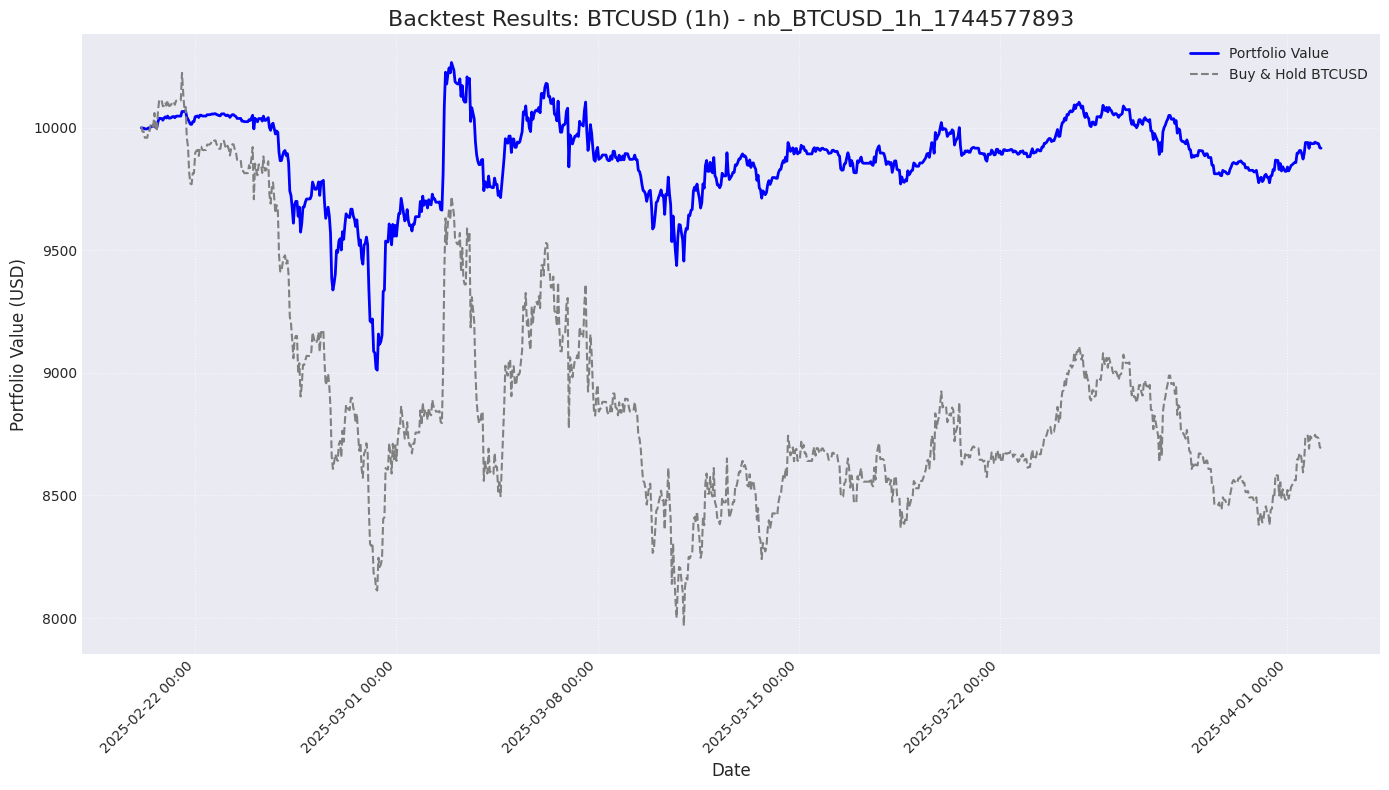

In [8]:
# --- Plot Equity Curve ---
logger.info("Plotting equity curve...")
equity_curve = results.get('equity_curve')

if equity_curve is None or equity_curve.empty:
    logger.warning("Equity curve data is missing or empty. Cannot plot.")
else:
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot portfolio value
    ax.plot(equity_curve.index, equity_curve['Value'], label='Portfolio Value', color='blue', linewidth=2)

    # --- Optional: Add Buy & Hold Benchmark ---
    if not historical_data.empty:
        try:
            # Get initial price for benchmark calculation (use first 'Open' or 'Close')
            initial_price = historical_data['Open'].iloc[0]
            if initial_price is None or initial_price <= 0: initial_price = historical_data['Close'].iloc[0]

            if initial_price and initial_price > 0:
                 # Calculate how much base asset could be bought initially
                 initial_base_buy = initial_portfolio_cash / initial_price
                 # Calculate Buy & Hold value over time
                 buy_hold_value = historical_data['Close'] * initial_base_buy
                 ax.plot(buy_hold_value.index, buy_hold_value, label=f'Buy & Hold {backtest_symbol}', color='grey', linestyle='--', linewidth=1.5)
            else:
                 logger.warning("Could not calculate Buy & Hold benchmark: Invalid initial price.")
        except Exception as bench_e:
             logger.warning(f"Could not calculate Buy & Hold benchmark: {bench_e}")


    # Formatting the plot
    ax.set_title(f'Backtest Results: {backtest_symbol} ({backtest_interval}) - {backtest_run_id}', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Portfolio Value (USD)', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.7)

    # Improve date formatting on x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

2025-04-13 20:58:14,872 - __main__ - INFO - Plotting equity curve...


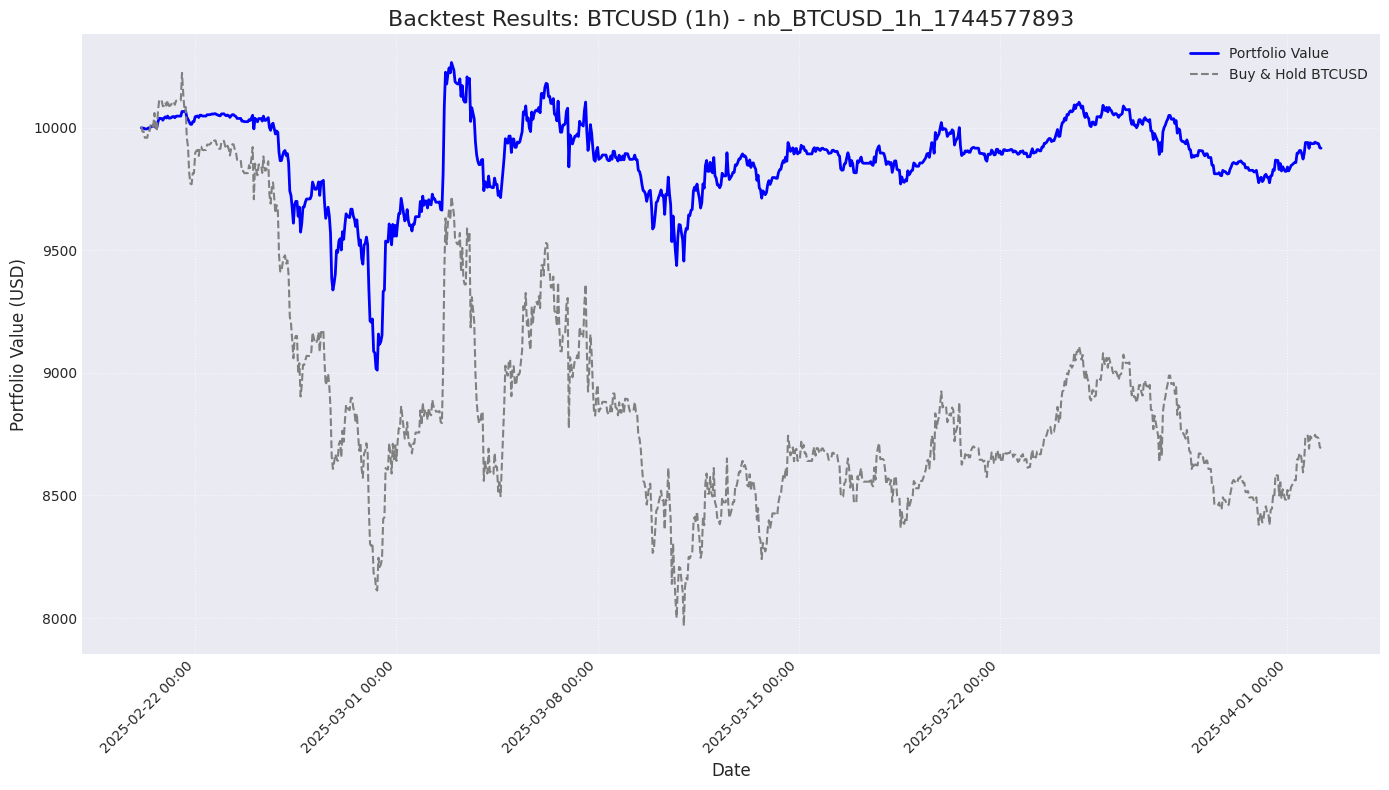

In [9]:
# --- Plot Equity Curve ---
logger.info("Plotting equity curve...")
equity_curve = results.get('equity_curve')

if equity_curve is None or equity_curve.empty:
    logger.warning("Equity curve data is missing or empty. Cannot plot.")
else:
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot portfolio value
    ax.plot(equity_curve.index, equity_curve['Value'], label='Portfolio Value', color='blue', linewidth=2)

    # --- Optional: Add Buy & Hold Benchmark ---
    if not historical_data.empty:
        try:
            # Get initial price for benchmark calculation (use first 'Open' or 'Close')
            initial_price = historical_data['Open'].iloc[0]
            if initial_price is None or initial_price <= 0: initial_price = historical_data['Close'].iloc[0]

            if initial_price and initial_price > 0:
                 # Calculate how much base asset could be bought initially
                 initial_base_buy = initial_portfolio_cash / initial_price
                 # Calculate Buy & Hold value over time
                 buy_hold_value = historical_data['Close'] * initial_base_buy
                 ax.plot(buy_hold_value.index, buy_hold_value, label=f'Buy & Hold {backtest_symbol}', color='grey', linestyle='--', linewidth=1.5)
            else:
                 logger.warning("Could not calculate Buy & Hold benchmark: Invalid initial price.")
        except Exception as bench_e:
             logger.warning(f"Could not calculate Buy & Hold benchmark: {bench_e}")


    # Formatting the plot
    ax.set_title(f'Backtest Results: {backtest_symbol} ({backtest_interval}) - {backtest_run_id}', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Portfolio Value (USD)', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.7)

    # Improve date formatting on x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()